In [39]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from queue import PriorityQueue

# Read the map and select start and goal location

In [71]:
%matplotlib tk
grid : np.ndarray = np.load('occupancy_grid.npy')
rows, cols = grid.shape

plt.imshow(grid, cmap='gray')
start_coords = plt.ginput(1, show_clicks=False)[0]
plt.scatter(start_coords[0], start_coords[1], c = 'b')

goal_coords = plt.ginput(1, show_clicks=False)[0]
plt.scatter(goal_coords[0], goal_coords[1], c = 'r')

goal_loc = (int(goal_coords[1]), int(goal_coords[0]))
start_loc = (int(start_coords[1]), int(start_coords[0]))

plt.show()

## Constructing Tree from nodes

In [59]:
class Node():
    def __init__(self, row:int, col:int, status: bool, neighbors_list: list[int]):
        self.loc = (row, col)
        self.is_free = status
        self.neighbors = neighbors_list

        self.cost_to_reach = np.inf
        self.est_cost_to_goal = np.inf
        self.predecessor = None

    def __str__(self):
        return(f"loc : {self.loc}\nstatus : {self.is_free}\ncost to reach: {self.cost_to_reach}\nest cost to goal: {self.est_cost_to_goal}")
    
    def __lt__(self, other):
        return self.est_cost_to_goal < other.est_cost_to_goal



# A Star

In [72]:
class AStar():
    def __init__(self, grid, start_loc, goal_loc):
        self.grid = grid
        self.rows = grid.shape[0]
        self.cols = grid.shape[1]
        self.nodes:dict[tuple[int, int]:Node] = {} 
        self.start_loc = start_loc
        self.goal_loc = goal_loc

    def get_neighbors(self, row, col):
        neighbors = []
        neighbors.append((row+1, col))
        neighbors.append((row-1, col))
        neighbors.append((row, col+1))
        neighbors.append((row, col-1))
        neighbors.append((row+1, col+1))
        neighbors.append((row-1, col-1))
        neighbors.append((row+1, col-1))
        neighbors.append((row-1, col+1))
    
        return list(filter(lambda n: not(n[0]<0 or n[1]<0 or n[0]>=self.rows or n[1]>=self.cols), neighbors))
    
    def distance(self, node_1:Node, node_2:Node):
        return np.linalg.norm([node_1.loc[0] - node_2.loc[0],
                               node_1.loc[1] - node_2.loc[1]])
    
    def heuristic(self, node:Node):
        return np.linalg.norm([node.loc[0] - self.goal_loc[0],
                               node.loc[1] - self.goal_loc[1]])
    
    def construct_tree(self): 
        for row in range(rows):
            for col in range(cols):
                neighbors = self.get_neighbors(row, col)
                self.nodes[(row, col)] = Node(row, col, status = bool(grid[row, col]), neighbors_list = neighbors)

    def recover_path(self):
        goal_node:Node = self.nodes[goal_loc]
        if goal_node.predecessor == None:
            print("PATH NOT FOUND!")
            return
        
        path = []
        curr_node = goal_node
        while curr_node.predecessor != None:
            path.append(curr_node.loc)
            curr_node = curr_node.predecessor

        return path

    def search(self):
        self.nodes[start_loc].est_cost_to_goal = self.heuristic(self.nodes[start_loc])
        self.nodes[start_loc].cost_to_reach = 0

        q = PriorityQueue()
        q.put(self.nodes[start_loc])

        # print(self.nodes[start_loc])

        while q:
            curr_node:Node = q.get()
            
            if curr_node.loc == self.goal_loc:
                print("PATH FOUND!")
                return self.recover_path()
            
            for neighbor_loc in curr_node.neighbors:
                neighbor:Node = self.nodes[neighbor_loc]
                
                if not neighbor.is_free:
                    continue

                cost = self.distance(curr_node, neighbor)

                if cost + curr_node.cost_to_reach < neighbor.cost_to_reach:
                    neighbor.predecessor = curr_node
                    neighbor.cost_to_reach =  cost + curr_node.cost_to_reach
                    neighbor.est_cost_to_goal = cost + curr_node.cost_to_reach + self.heuristic(neighbor)
                    q.put(neighbor)



a_star = AStar(grid, start_loc, goal_loc)
a_star.construct_tree()
path = a_star.search()

PATH FOUND!


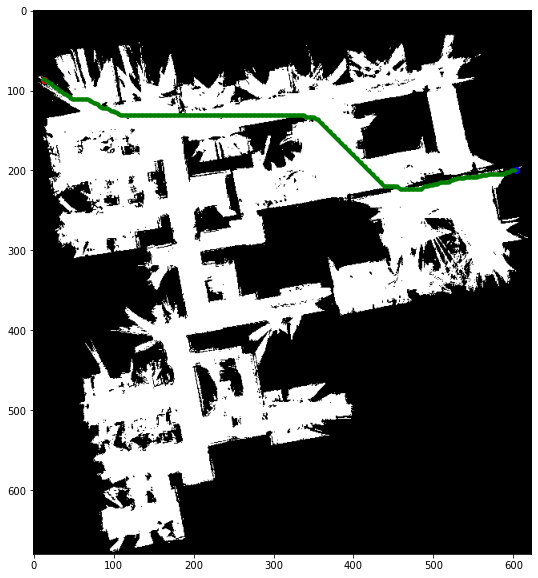

In [73]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(grid, cmap='gray')
plt.scatter(start_coords[0], start_coords[1], c = 'b')
plt.scatter(goal_coords[0], goal_coords[1], c = 'r')
for p in path:
    plt.scatter(p[1], p[0], c='g', marker=".")